# Quote Calculator Using OpenAI (Chatbot)

## Preparing Data

Creating a synthetic prompts data set for validation and training.

In [1]:
training_data_template = [
    {
        'prompt': '!pn page!pp ->', 
        'completion' : ' A !pn page!pp website will cost you around $!wc. It can build in !wt day!dp #'
    },
    {
        'prompt': 'How much a website that consisits of !pn page!pp cost? ->', 
        'completion' : ' A !pn page!pp website will cost you around $!wc. It can build in !wt day!dp #'
    },
    {
        'prompt': 'Can you share a quote and timeline for a website of !pn page!pp? ->', 
        'completion' : ' A !pn page!pp website will cost you around $!wc. It can build in !wt day!dp #'
    },
    {
        'prompt': 'Wondering how much a website of !pn page!pp cost? ->', 
        'completion' : ' A !pn page!pp website will cost you around $!wc. It can build in !wt day!dp #'
    },
    {
        'prompt': 'Can you guys build a website for us? The website has !pn page!pp ->', 
        'completion' : ' Yes we can surely, help you with that! A !pn page!pp website will cost you around $!wc. It can build in !wt day!dp #'
    },
    
]

In [3]:
import nltk, random

training_data = []
for i in range(500):
    prompt = {}
    
    plural_pages = 's' if (i + 1) > 1 else ''
    index = random.randint(0, 4)
    prompt['prompt'] = training_data_template[index]['prompt']\
                        .replace('!pn', str(i + 1))\
                        .replace('!pp', plural_pages)
    
    days_for_prompt = 2 * (i + 1)
    plural_days = 's' if (days_for_prompt) > 1 else ''
    prompt['completion'] = training_data_template[index]['completion']\
                            .replace('!pn', str(i + 1))\
                            .replace('!wc', str(1000 * (i + 1)))\
                            .replace('!wt', str(2 * (i + 1)))\
                            .replace('!wt', str(2 * (i + 1)))\
                            .replace('!dp', plural_days)\
                            .replace('!pp', plural_pages)
    
    token_count = nltk.word_tokenize(prompt['prompt'] + prompt['completion'] )

    prompt['tokens'] = len(token_count)
    training_data.append(prompt)

validation_data = []
for i in range(500, 1000):
    prompt = {}
    index = random.randint(0, 4)
    plural_pages = 's' if (i + 1) > 1 else ''
    prompt['prompt'] = training_data_template[index]['prompt']\
                        .replace('!pn', str(i + 1))\
                        .replace('!pp', plural_pages)
    
    days_for_prompt = 2 * (i + 1)
    plural_days = 's' if (days_for_prompt) > 1 else ''
    prompt['completion'] = training_data_template[index]['completion']\
                            .replace('!pn', str(i + 1))\
                            .replace('!wc', str(1000 * (i + 1)))\
                            .replace('!wt', str(2 * (i + 1)))\
                            .replace('!wt', str(2 * (i + 1)))\
                            .replace('!dp', plural_days)\
                            .replace('!pp', plural_pages)

    validation_data.append(prompt)



## Exploring Data

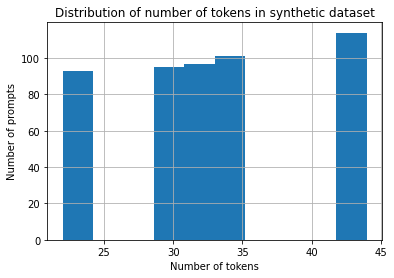

In [4]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.DataFrame(training_data)
df.head()


df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of prompts')
plt.title('Distribution of number of tokens in synthetic dataset')
plt.show()


trainig_data_final = [{k: v for k, v in d.items() if k != 'tokens'} for d in training_data]


As you can see the majority of the prompts have between 25 to 35 tokens

## Fine-tuning the Model

### Preparing and Validating the Training and Validation data files

In [95]:
!pip install openai

In [24]:
import json

training_file_name = "training_data.jsonl"
validation_file_name = "validation_data.jsonl"

def prepare_data(dictionary_data, final_file_name):
    with open(final_file_name, 'w') as outfile:
        for entry in dictionary_data:
            json.dump(entry, outfile)
            outfile.write('\n')

prepare_data(trainig_data_final, "training_data.jsonl")
prepare_data(validation_data, "validation_data.jsonl")

In [25]:
!openai tools fine_tunes.prepare_data -f "training_data.jsonl"
!openai tools fine_tunes.prepare_data -f "validation_data.jsonl"

Analyzing...

- Your file contains 500 prompt-completion pairs
- All prompts end with suffix ` ->`
- All completions end with suffix ` days #`

No remediations found.

You can use your file for fine-tuning:
> openai api fine_tunes.create -t "training_data.jsonl"

After you’ve fine-tuned a model, remember that your prompt has to end with the indicator string ` ->` for the model to start generating completions, rather than continuing with the prompt. Make sure to include `stop=[" days #"]` so that the generated texts ends at the expected place.
Once your model starts training, it'll approximately take 9.31 minutes to train a `curie` model, and less for `ada` and `babbage`. Queue will approximately take half an hour per job ahead of you.
Analyzing...

- Your file contains 500 prompt-completion pairs
- All prompts end with suffix ` ->`
- All completions end with suffix ` days #`

No remediations found.

You can use your file for fine-tuning:
> openai api fine_tunes.create -t "validation_da

**OpenAI is satisfied with the data.**

### Fine-tune job

In [ ]:
!openai api fine_tunes.create -t training_data.jsonl \
    -v validation_data.jsonl \
    -m babbage \
    --n_epochs 15 \
    --batch_size 3 \
    --learning_rate_multiplier 0.3

In [ ]:
!openai api fine_tunes.get -i ft-kDQkbgb8r3XNE9mp6UrNbl85

## Evaluating Inference Results

In [14]:
!openai api completions.create -m babbage:ft-personal-2023-08-02-23-37-50 -p 'What is the cost of 10 page website? ->'

What is the cost of 10 page website? -> A 10 page website will cost you around $10000. It can build in 20

### Relevance Score

In [16]:
import openai

docs = ["Wondering how much a website of 1 page cost?", "How much a website that consisits of 4 pages cost?", "Can you guys build a website for us? The website has 509 pages", "Can you share a quote and timeline for a website of 572 pages?"]
query = "500 page website quote?"


def construct_context(query, document):
    return "<|endoftext|>{document}\n\n---\n\nThe above passage is related to: {query}".format(
        document=document, query=query
    )


def get_score(context, query, log_probs, text_offsets) -> float:
    SCORE_MULTIPLIER = 100.0

    log_prob = 0
    count = 0
    cutoff = len(context) - len(query)

    for i in range(len(text_offsets) - 1, 0, -1):
        log_prob += log_probs[i]
        count += 1

        if text_offsets[i] <= cutoff and text_offsets[i] != text_offsets[i - 1]:
            break

    return log_prob / float(count) * SCORE_MULTIPLIER


def search(query, documents, engine):

    prompts = [construct_context(query, doc) for doc in [""] + documents]
    # print(prompts)
    resps = openai.Completion.create(
        model=engine,
        prompt=prompts,
        temperature=1.0,
        top_p=1.0,
        max_tokens=0,
        logprobs=0,
        n=1,
        echo=True,
    )

    resps_by_index = {choice["index"]: choice for choice in resps["choices"]}
    
    #for i in range(len(resps_by_index)):
        #print(resps_by_index[i]['text'] )
    
    scores = [
        get_score(
            prompts[i],
            query,
            resps_by_index[i]["logprobs"]["token_logprobs"],
            resps_by_index[i]["logprobs"]["text_offset"],
        )
        for i in range(len(prompts))
    ]

    # Process results
    scores = [score - scores[0] for score in scores][1:]

    return [
        {
            "object": "search_result",
            "document": document_idx,
            "score": round(score, 3),
        }
        for document_idx, score in enumerate(scores)
    ]


print(search(query=query, documents=docs, engine="babbage:ft-personal-2023-08-02-23-37-50"))

[{'object': 'search_result', 'document': 0, 'score': 81.088}, {'object': 'search_result', 'document': 1, 'score': 27.858}, {'object': 'search_result', 'document': 2, 'score': -80.206}, {'object': 'search_result', 'document': 3, 'score': 103.04}]


**You can see above that the model was able to recognize the context correctly.**

### Evaluation metric for the fine-tuned model

In [21]:
!openai api fine_tunes.results -i ft-kDQkbgb8r3XNE9mp6UrNbl85 > result.csv

## Testing the model

In [13]:
answer = openai.Completion.create(
  model="babbage:ft-personal-2023-08-02-23-37-50",
  prompt="share the cost of 4 page website ->",
  max_tokens=10, # Change amount of tokens for longer completion
  temperature=0
)
answer['choices'][0]['text']

' A 4 page website will cost you around $4000'

**The model gave the correct result!!!!**